## 1. Connecting to database

In [44]:
# importing required modules for connecting to pgAdmin4
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from numpy import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from config import hostname, database, username, password, port_id

%matplotlib inline

In [3]:
try:
    conn = psycopg2.connect(
        host = hostname,
        dbname = database,
        user = username,
        password = password,
        port = port_id)
    print("Connected to the database!")

except Exception as e:
    print(f"Unable to connect to the database. Error: {e}")

Connected to the database!


In [4]:
sql_query = "SELECT * FROM binary_diabetes_dataset"
classifier_data = pd.read_sql_query(sql_query, conn)

C:\Users\daian\AppData\Local\Temp\ipykernel_19876\460499187.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  classifier_data = pd.read_sql_query(sql_query, conn)


In [5]:
conn.close()

In [6]:
pd.set_option('display.max_columns', 20)
classifier_data.head()

,Diabetes,BMICategory,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,HealthcarePlan,NoDocbcCost,GeneralHealth,MentalHealth,PhysicalHealth,DifficultyWalking,Sex,AgeCategory,EducationLevel,Income
0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,2.0,5.0
1,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,2.0,0.0,0.0,8.0,4.0,10.0
2,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,5.0,3.0,5.0
3,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,13.0,4.0,8.0
4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,13.0,2.0,7.0


In [7]:
classifier_data.groupby(['Diabetes']).size()

Diabetes
0.0    211801
1.0      5893
2.0     35194
dtype: int64

* 0 = no diabetes
* 1 = pre-diabetes
* 2 = diabetes

In [8]:
classifier_data.describe()

,Diabetes,BMICategory,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,HealthcarePlan,NoDocbcCost,GeneralHealth,MentalHealth,PhysicalHealth,DifficultyWalking,Sex,AgeCategory,EducationLevel,Income
count,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000,252888.000000
mean,0.301639,3.043403,0.409656,0.041655,0.091483,0.775636,0.071407,0.044367,0.077497,2.532532,4.336382,4.267134,0.151518,0.487548,7.718116,3.143423,6.963328
std,0.699279,0.827122,0.491771,0.199799,0.288296,0.417164,0.257504,0.205911,0.267379,1.032911,8.243709,8.545156,0.358553,0.499846,3.421319,0.912323,2.409805
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,5.000000
50%,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,3.000000,7.000000
75%,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,5.000000,3.000000,0.000000,1.000000,10.000000,4.000000,9.000000
max,2.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,4.000000,11.000000


##### Checking the correlation between features

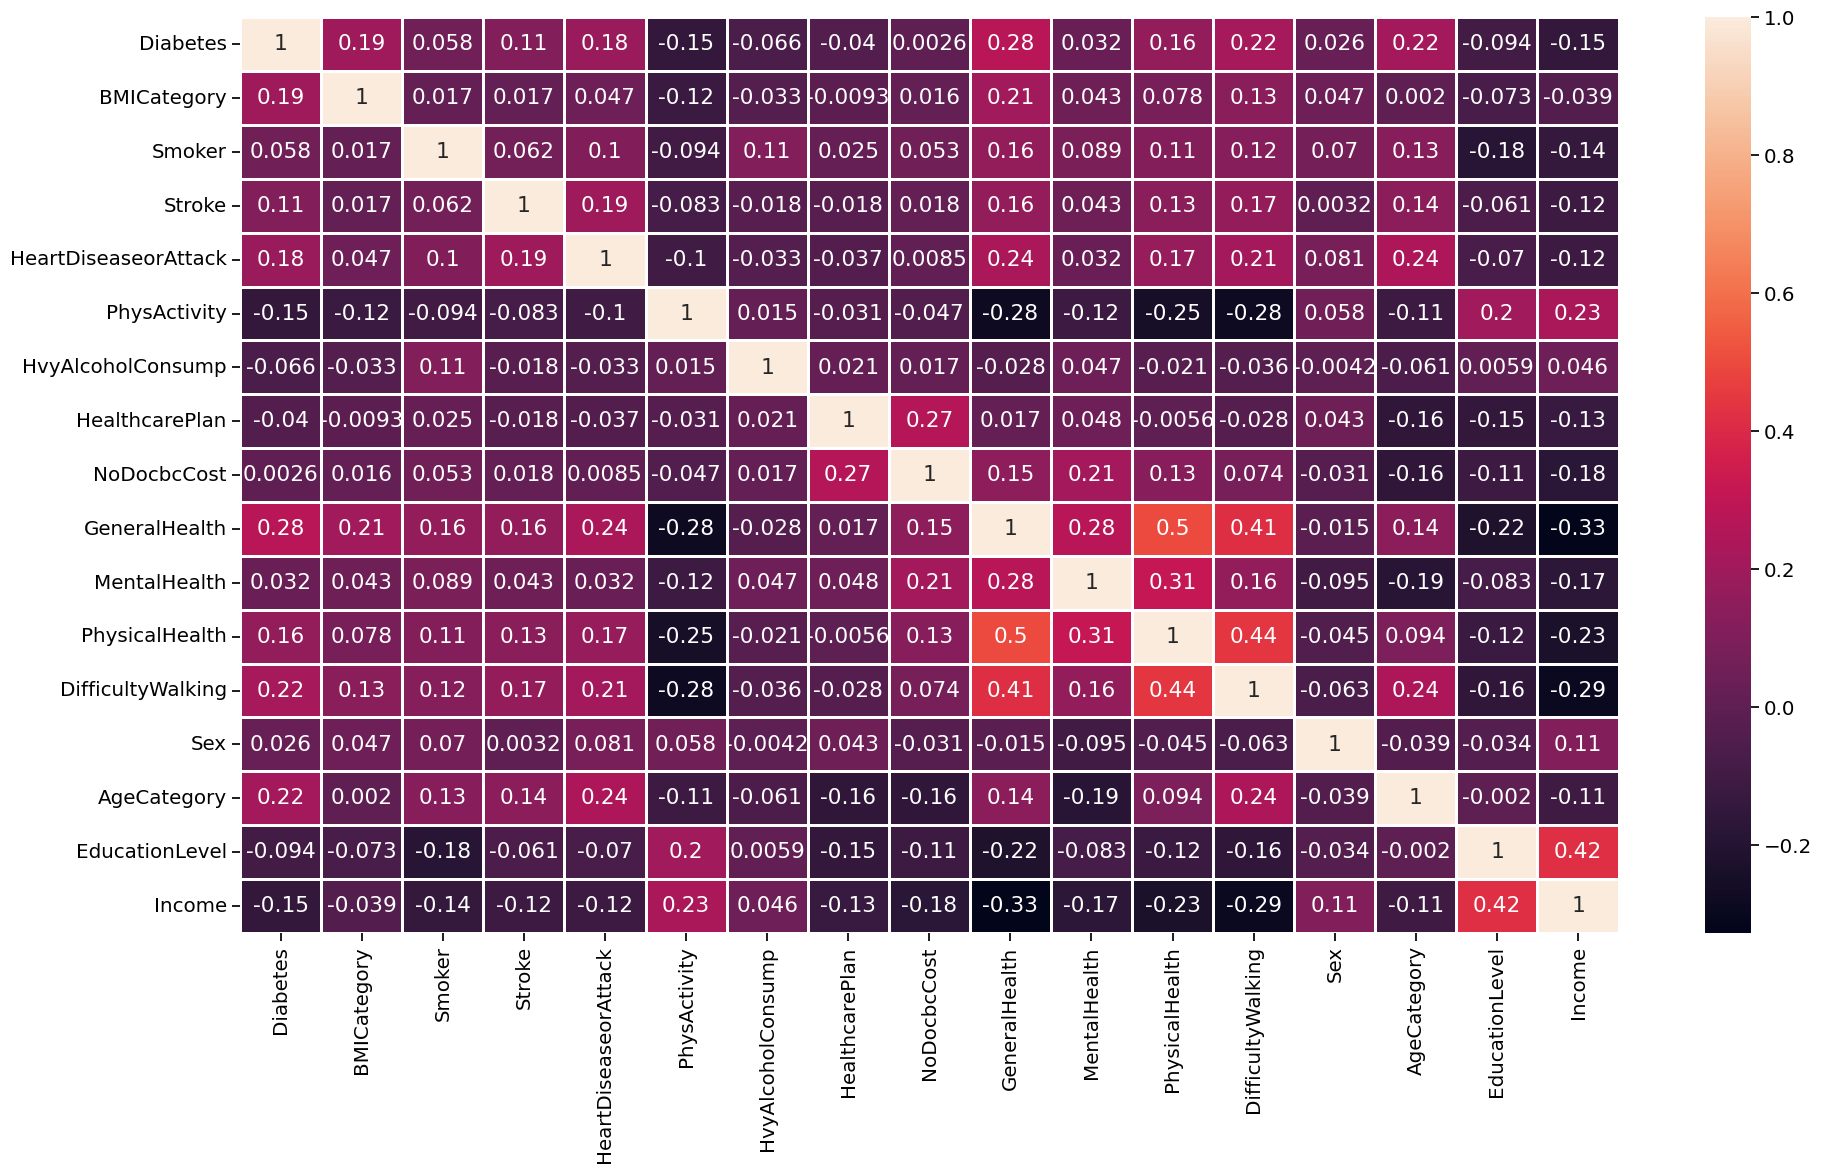

In [9]:
plt.figure(figsize=(20,12))
sns.set_context('notebook',font_scale = 1.3)
sns.heatmap(classifier_data.corr(),annot=True,linewidth =2)
plt.tight_layout()

# 2. Creating the binary dataset for predicting diabetes
1. Join prediabetes & diabetes since we want to use this as a predicition for people who could be flagged as diabetic. 
2. Balance the dataset.

In [10]:
# creating a copy of the data
binary_df = classifier_data

In [11]:
# changing diabetes 2 to 1 and predibetics 1 to 0 so that prediabetics and diabetics are in the same class
binary_df['Diabetes'] = binary_df['Diabetes'].replace({1:0, 2:1})
binary_df.Diabetes.value_counts()

0.0    217694
1.0     35194
Name: Diabetes, dtype: int64

Since there is class imbalance, different techniques will be used to evaluate the best data and model combination. The methods listed below will be used to deal wit the class imbalance:
1. Resampling technique
2. Using different evaluation metrics
3. Different algorithms

The follow models will be evaluated:
1. K-Nearest Neighbours
2. Random Forest
3. Deep neural networks

#### 2.1 Resampling the data to 50/50

In [12]:
# separating the 0 and 1
diabetes = binary_df[binary_df['Diabetes'] == 1]
no_diabetes = binary_df[binary_df['Diabetes'] == 0]

# next we select 35,194 random entries from the 0 group since we have 35,194 entries of the 1 group
random_diabetes_selection = no_diabetes.take(np.random.permutation(len(no_diabetes))[:35194])

new_diabetes_df = random_diabetes_selection.append(diabetes, ignore_index=True)

C:\Users\daian\AppData\Local\Temp\ipykernel_19876\737260662.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_diabetes_df = random_diabetes_selection.append(diabetes, ignore_index=True)


In [13]:
new_diabetes_df.head()

,Diabetes,BMICategory,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,HealthcarePlan,NoDocbcCost,GeneralHealth,MentalHealth,PhysicalHealth,DifficultyWalking,Sex,AgeCategory,EducationLevel,Income
0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0
1,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,5.0
2,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,2.0,4.0,0.0,1.0,7.0,2.0,1.0
3,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,10.0,4.0,0.0,0.0,10.0,3.0,4.0
4,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,12.0,4.0,7.0


In [14]:
new_diabetes_df.tail()

,Diabetes,BMICategory,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,HealthcarePlan,NoDocbcCost,GeneralHealth,MentalHealth,PhysicalHealth,DifficultyWalking,Sex,AgeCategory,EducationLevel,Income
70383,1.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,12.0,2.0,7.0
70384,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,30.0,1.0,1.0,11.0,2.0,2.0
70385,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,13.0,1.0,5.0
70386,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,7.0,0.0,0.0,1.0,1.0,2.0,1.0
70387,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,15.0,0.0,0.0,1.0,10.0,4.0,9.0


In [15]:
new_diabetes_df['Diabetes'].value_counts()

0.0    35194
1.0    35194
Name: Diabetes, dtype: int64

Now that we have an even 50/50 split dataset, we can use this to prepare the data for the model.

##### 2.1.1 K-Nearest Neighbour Model

In [16]:
# splitting the data into a training and testing set
target_variable = new_diabetes_df['Diabetes']
features = new_diabetes_df.drop(columns = 'Diabetes')

In [17]:
# previewing the first five entries of the features dataframe
features[:5]

,BMICategory,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,HealthcarePlan,NoDocbcCost,GeneralHealth,MentalHealth,PhysicalHealth,DifficultyWalking,Sex,AgeCategory,EducationLevel,Income
0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0
1,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,5.0
2,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,2.0,4.0,0.0,1.0,7.0,2.0,1.0
3,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,10.0,4.0,0.0,0.0,10.0,3.0,4.0
4,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,12.0,4.0,7.0


In [18]:
# previewing the first five entries for the target array
target_variable[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes, dtype: float64

In [19]:
# split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(features, target_variable, random_state=42, stratify=target_variable)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [21]:
# Instantiate the model with k = 2 neighbors 
model = KNeighborsClassifier(n_neighbors = 2)

In [22]:
# Train the model
model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=2)

In [23]:
# Create predictions
y_pred = model.predict(X_test_scaled)

# Review the predictions
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
# Print confusion matrix
confusion_matrix(y_pred, y_test)

array([[7026, 4744],
       [1773, 4054]], dtype=int64)

In [25]:
# Print classification report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.80      0.60      0.68     11770
         1.0       0.46      0.70      0.55      5827

    accuracy                           0.63     17597
   macro avg       0.63      0.65      0.62     17597
weighted avg       0.69      0.63      0.64     17597



##### 2.1.2 Random Forest Model

In [26]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [27]:
# Calculating the confusion matrix
cm_randomForest = confusion_matrix(y_test, predictions)

# Calculating the accuracy score
acc_score_randomForest = accuracy_score(y_test, predictions)

In [28]:
# Displaying results
print("Confusion Matrix")
display(cm_randomForest)
print(f"Accuracy Score : {acc_score_randomForest}\n")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


array([[5912, 2887],
       [2374, 6424]], dtype=int64)

Accuracy Score : 0.7010285844177985

Classification Report
              precision    recall  f1-score   support

         0.0       0.71      0.67      0.69      8799
         1.0       0.69      0.73      0.71      8798

    accuracy                           0.70     17597
   macro avg       0.70      0.70      0.70     17597
weighted avg       0.70      0.70      0.70     17597



In [29]:
# understanding of feature importance
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_

# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, features.columns), reverse=True)

[(0.20547420735622077, 'AgeCategory'),
 (0.1502163030333297, 'Income'),
 (0.11792855746448008, 'GeneralHealth'),
 (0.101223640720675, 'PhysicalHealth'),
 (0.09041302847635004, 'MentalHealth'),
 (0.07267386179350109, 'EducationLevel'),
 (0.06392211317359613, 'BMICategory'),
 (0.03584361864837007, 'Smoker'),
 (0.03260819652365676, 'DifficultyWalking'),
 (0.03233962736367269, 'Sex'),
 (0.026056772714213146, 'PhysActivity'),
 (0.023731507538065164, 'HeartDiseaseorAttack'),
 (0.01361139271678059, 'NoDocbcCost'),
 (0.013287941065709036, 'Stroke'),
 (0.012614278136723521, 'HvyAlcoholConsump'),
 (0.008054953274656258, 'HealthcarePlan')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

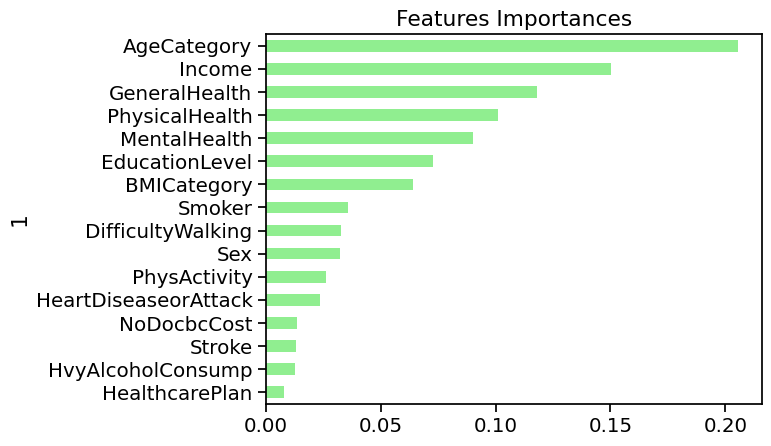

In [30]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, features.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

##### 2.1.3 Deep Learning Model

In [31]:
dim = features.shape[1]
dim

16

In [32]:
# Define the deep learning model 
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=16, activation="tanh", input_dim=dim))
nn_model.add(tf.keras.layers.Dense(units=16, activation="tanh"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=200)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5465 - accuracy: 0.7274
Epoch 2/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5377 - accuracy: 0.7311
Epoch 3/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5345 - accuracy: 0.7328
Epoch 4/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5331 - accuracy: 0.7330
Epoch 5/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5318 - accuracy: 0.7346
Epoch 6/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5314 - accuracy: 0.7348
Epoch 7/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5307 - accuracy: 0.7335
Epoch 8/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5306 - accuracy: 0.7351
Epoch 9/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5300 - accuracy: 0.7340
Epoch 10/200
1650/1650 [==============================] - 3s 2ms/step - l

1650/1650 [==============================] - 3s 2ms/step - loss: 0.5226 - accuracy: 0.7404
Epoch 80/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5224 - accuracy: 0.7394
Epoch 81/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5225 - accuracy: 0.7404
Epoch 82/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5224 - accuracy: 0.7404
Epoch 83/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5222 - accuracy: 0.7402
Epoch 84/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5223 - accuracy: 0.7401
Epoch 85/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5222 - accuracy: 0.7409
Epoch 86/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5220 - accuracy: 0.7398
Epoch 87/200
1650/1650 [==============================] - 3s 2ms/step - loss: 0.5221 - accuracy: 0.7403
Epoch 88/200
1650/1650 [==============================] - 3s 2ms/step - loss:

1650/1650 [==============================] - 4s 2ms/step - loss: 0.5198 - accuracy: 0.7417
Epoch 158/200
1650/1650 [==============================] - 7s 4ms/step - loss: 0.5200 - accuracy: 0.7427
Epoch 159/200
1650/1650 [==============================] - 6s 4ms/step - loss: 0.5198 - accuracy: 0.7410
Epoch 160/200
1650/1650 [==============================] - 5s 3ms/step - loss: 0.5198 - accuracy: 0.7415
Epoch 161/200
1650/1650 [==============================] - 4s 2ms/step - loss: 0.5199 - accuracy: 0.7409
Epoch 162/200
1650/1650 [==============================] - 4s 2ms/step - loss: 0.5197 - accuracy: 0.7417
Epoch 163/200
1650/1650 [==============================] - 4s 2ms/step - loss: 0.5198 - accuracy: 0.7419
Epoch 164/200
1650/1650 [==============================] - 4s 2ms/step - loss: 0.5196 - accuracy: 0.7423
Epoch 165/200
1650/1650 [==============================] - 4s 2ms/step - loss: 0.5197 - accuracy: 0.7407
Epoch 166/200
1650/1650 [==============================] - 5s 3ms/ste

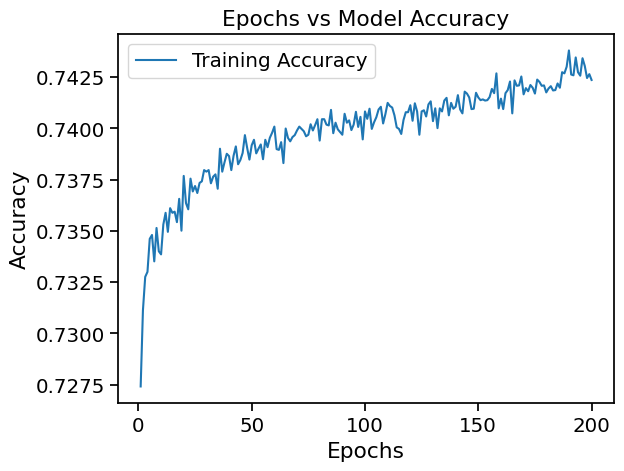

In [33]:
# extract accuracy values from the training history
train_accuracy = fit_model.history['accuracy']
epochs = range(1, len(train_accuracy) + 1)

# plot epochs vs accuracy
plt.plot(epochs, train_accuracy, label = 'Training Accuracy')
plt.title('Epochs vs Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 2.2 Using the original dataframe

In [34]:
binary_df.head()

,Diabetes,BMICategory,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,HealthcarePlan,NoDocbcCost,GeneralHealth,MentalHealth,PhysicalHealth,DifficultyWalking,Sex,AgeCategory,EducationLevel,Income
0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,2.0,5.0
1,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,2.0,0.0,0.0,8.0,4.0,10.0
2,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,5.0,3.0,5.0
3,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,13.0,4.0,8.0
4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,13.0,2.0,7.0


In [35]:
# splitting the data into a training and testing set
target_variable = binary_df['Diabetes']
features = binary_df.drop(columns = 'Diabetes')

# split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(features, target_variable, random_state=42, stratify=target_variable)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

##### 2.2.1 K-Nearest Neighbour Model


In [36]:
# Instantiate the model with k = 2 neighbors 
model = KNeighborsClassifier(n_neighbors = 2)

# Train the model
model.fit(X_train_scaled, y_train)

# Create predictions
y_pred = model.predict(X_test_scaled)

In [37]:
# Print confusion matrix
print('Confusion matrix:\n', confusion_matrix(y_pred, y_test))
print('\n')

# Print classification report
print('Classification Report:\n', classification_report(y_pred, y_test))

Confusion matrix:
 [[52820  7948]
 [ 1604   850]]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.87      0.92     60768
         1.0       0.10      0.35      0.15      2454

    accuracy                           0.85     63222
   macro avg       0.53      0.61      0.53     63222
weighted avg       0.94      0.85      0.89     63222



##### 2.2.2 Random Forest Model

In [38]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [39]:
# Calculating the confusion matrix
cm_randomForest = confusion_matrix(y_test, predictions)

# Calculating the accuracy score
acc_score_randomForest = accuracy_score(y_test, predictions)

In [40]:
# Displaying results
print("Confusion Matrix")
display(cm_randomForest)
print(f"Accuracy Score : {acc_score_randomForest}\n")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


array([[52271,  2153],
       [ 7464,  1334]], dtype=int64)

Accuracy Score : 0.8478852298250609

Classification Report
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92     54424
         1.0       0.38      0.15      0.22      8798

    accuracy                           0.85     63222
   macro avg       0.63      0.56      0.57     63222
weighted avg       0.81      0.85      0.82     63222



##### 2.2.3 Deep Learning Model

In [41]:
# Define the deep learning model 
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=16, activation="tanh", input_dim=dim))
nn_model.add(tf.keras.layers.Dense(units=16, activation="tanh"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
5928/5928 [==============================] - 11s 2ms/step - loss: 0.3389 - accuracy: 0.8571
Epoch 2/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3297 - accuracy: 0.8616
Epoch 3/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3280 - accuracy: 0.8623
Epoch 4/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3274 - accuracy: 0.8625
Epoch 5/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3269 - accuracy: 0.8623
Epoch 6/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3266 - accuracy: 0.8625
Epoch 7/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3264 - accuracy: 0.8626
Epoch 8/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3263 - accuracy: 0.8629
Epoch 9/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3261 - accuracy: 0.8630
Epoch 10/100
5928/5928 [==============================] - 10s 2m

5928/5928 [==============================] - 10s 2ms/step - loss: 0.3236 - accuracy: 0.8635
Epoch 80/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3237 - accuracy: 0.8637
Epoch 81/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3236 - accuracy: 0.8638
Epoch 82/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3236 - accuracy: 0.8636
Epoch 83/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3236 - accuracy: 0.8636
Epoch 84/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3236 - accuracy: 0.8634
Epoch 85/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3236 - accuracy: 0.8636
Epoch 86/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3236 - accuracy: 0.8637
Epoch 87/100
5928/5928 [==============================] - 10s 2ms/step - loss: 0.3237 - accuracy: 0.8635
Epoch 88/100
5928/5928 [==============================] - 10s 2ms/st

In [42]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1976/1976 - 2s - loss: 0.3302 - accuracy: 0.8623 - 2s/epoch - 1ms/step
Loss: 0.33023887872695923, Accuracy: 0.8623105883598328


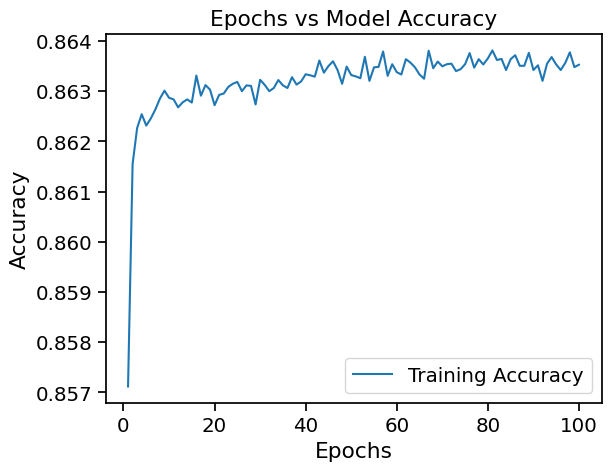

In [43]:
# extract accuracy values from the training history
train_accuracy = fit_model.history['accuracy']
epochs = range(1, len(train_accuracy) + 1)

# plot epochs vs accuracy
plt.plot(epochs, train_accuracy, label = 'Training Accuracy')
plt.title('Epochs vs Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 2.3 SMOTE, SMOTEENN, & ADASYN for imbalanced classification
* https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#:~:text=SMOTE%20is%20an%20oversampling%20technique%20that%20generates%20synthetic%20samples%20from,set%2C%20then%20trains%20the%20classifier.

* https://github.com/Swastik-25/Imbalanced-Data-with-SMOTE-Techniques/blob/main/Imbalanced_Data.ipynb

In [ ]:
target_variable = binary_df['Diabetes']
features = binary_df.drop(columns = 'Diabetes')

In [ ]:
# split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(features, target_variable, random_state=42, stratify=target_variable)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTETomek
from imblearn.over_sampling import ADASYN

counter = Counter(y_train)
print('Before', counter)

# oversampling the train dataset using SMOTE + ENN + ADASYN
smenn = SMOTEENN()
smt = SMOTE()
ada = ADASYN(random_state=130)
smtom = SMOTETomek(random_state=139)

X_train_smenn, y_train_smenn = smenn.fit_resample(X_train_scaled, y_train) # SMOTE + ENN algorithm
X_train_sm, y_train_sm = smt.fit_resample(X_train_scaled, y_train) # SMOTE algorithm
X_train_ada, y_train_ada = ada.fit_resample(X_train_scaled, y_train) # ADASYN algorithm
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train_scaled, y_train) # SMOTE + Tomek algorithm

print('After SMOTE:', y_train_sm)
print('After SMOTEENN:', y_train_smenn)
print('After ADASYN:', y_train_ada)
print('After SMOTETomek:', y_train_smtom)